In [2]:
#Import Standard Dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Import tensorfloe dependecies- Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
#Avoid OOM erros by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
# Setup Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
# Make the directiories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [1]:
#Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [5]:
# Move lFW Images to Negative Repo
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [7]:
#Import UUID
import uuid

In [86]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [8]:
# Get Image Directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [9]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\5c17b3f2-068c-11ee-af92-a87eea9e8aaa.jpg'


In [10]:
def preprocess(file_path):
    #Read in image from file path
    byte_img = tf.io.read_file(file_path)
    
    #Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    #Scale Image to be between 0 and 1
    img = img/255.0
    
    return img

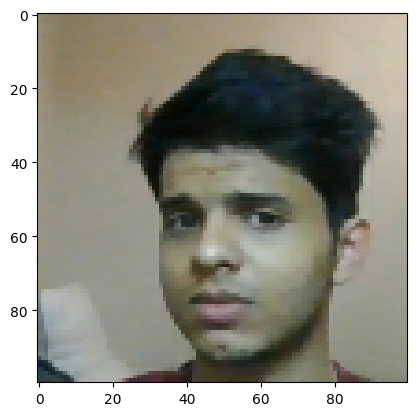

In [11]:
img = preprocess('data\\anchor\\5c17b3f2-068c-11ee-af92-a87eea9e8aaa.jpg')
plt.imshow(img)

In [44]:
img.numpy().max()

0.8477941

In [47]:
#Creating Labeled dataset
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [48]:
samples = data.as_numpy_iterator()
example = next(samples)
output = (example[0], example[1], example[2])
print(output)

(b'data\\anchor\\6bbe40f9-068c-11ee-948e-a87eea9e8aaa.jpg', b'data\\positive\\8a0030bb-068c-11ee-af4f-a87eea9e8aaa.jpg', 1.0)


In [15]:
#Build Train and Test Partition
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [16]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [17]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [18]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [19]:
train_sample = train_data.as_numpy_iterator()
train_sample = train_sample.next()

In [20]:
len(train_sample[0])

16

In [21]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [49]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [23]:
embedding = make_embedding()

In [24]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [50]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [51]:
l1 = L1Dist()

In [52]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [53]:
siamese_model = make_siamese_model()

In [54]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [55]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [56]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [57]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [58]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [59]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [35]:
EPOCHS = 50

In [77]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 13s 395ms/step

 Epoch 2/50
27/27 [==============================] - 10s 383ms/step

 Epoch 3/50
27/27 [==============================] - 10s 382ms/step

 Epoch 4/50
27/27 [==============================] - 10s 383ms/step

 Epoch 5/50
27/27 [==============================] - 10s 385ms/step

 Epoch 6/50
27/27 [==============================] - 10s 386ms/step

 Epoch 7/50
27/27 [==============================] - 10s 385ms/step

 Epoch 8/50
27/27 [==============================] - 10s 381ms/step

 Epoch 9/50
27/27 [==============================] - 10s 381ms/step

 Epoch 10/50
27/27 [==============================] - 10s 381ms/step

 Epoch 11/50
27/27 [==============================] - 11s 433ms/step

 Epoch 12/50
27/27 [==============================] - 12s 458ms/step

 Epoch 13/50
2

In [78]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [79]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [80]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 29ms/step


array([[9.9999988e-01],
       [1.2796047e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.8901207e-07],
       [1.0000000e+00],
       [3.2271674e-10],
       [1.0000000e+00],
       [1.3171000e-08],
       [1.1259217e-09],
       [9.9967480e-01],
       [1.0000000e+00],
       [4.4526209e-07],
       [1.0000000e+00],
       [9.9969423e-01],
       [1.0000000e+00]], dtype=float32)

In [81]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1]

In [82]:
y_true

array([1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [83]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [84]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

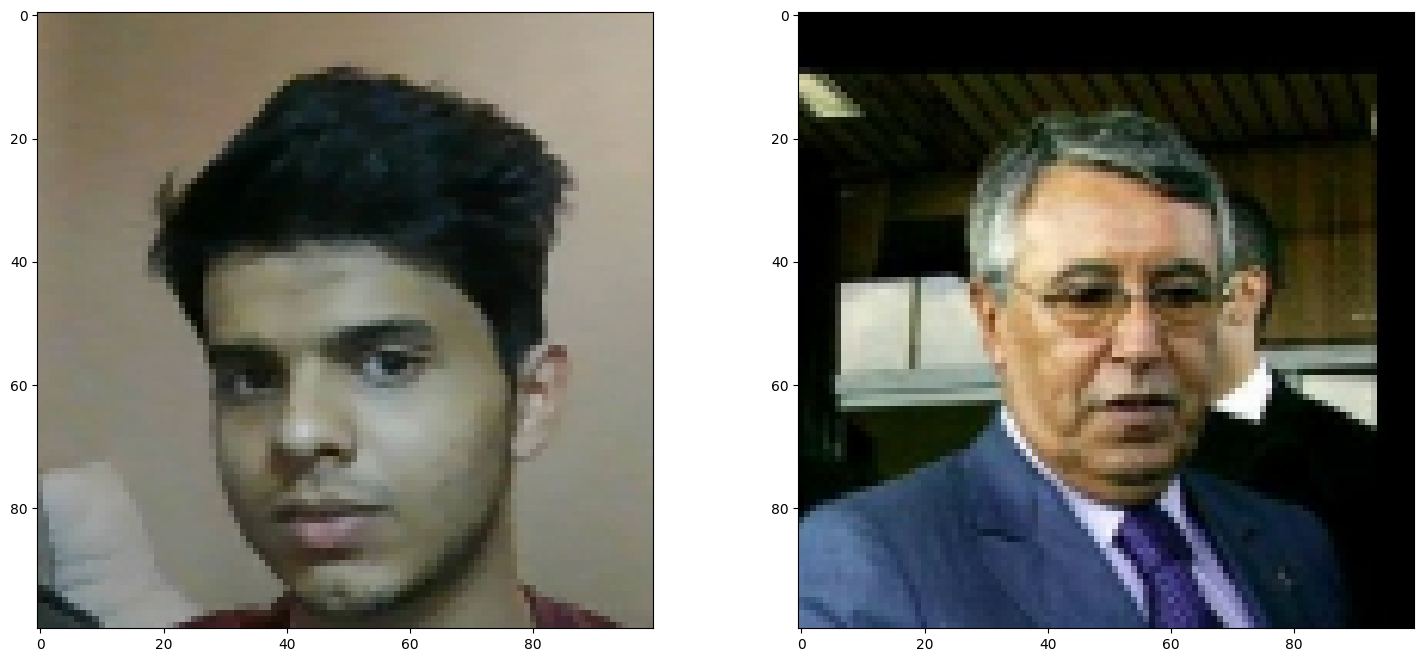

In [87]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

In [89]:
siamese_model.compile(optimizer='adam', loss='binary_crossentropy')
siamese_model.save('NewModel.h5')

In [90]:
# Reload model 
model = tf.keras.models.load_model('NewModel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [91]:
model.predict([test_input, test_val])

1/1 [==============================] - 0s 109ms/step


array([[9.9999988e-01],
       [1.2796047e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.8901207e-07],
       [1.0000000e+00],
       [3.2271674e-10],
       [1.0000000e+00],
       [1.3171000e-08],
       [1.1259217e-09],
       [9.9967480e-01],
       [1.0000000e+00],
       [4.4526209e-07],
       [1.0000000e+00],
       [9.9969423e-01],
       [1.0000000e+00]], dtype=float32)

In [92]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [93]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [130]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.5, 0.3)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 20ms/step
True
1/1 [==============================] - 0s 24ms/step
True
1/1 [==============================] - 0s 20ms/step
False
1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 41ms/step
False


In [127]:
np.sum(np.squeeze(results) > 0.9)

32